# <center><h1 style = "color:navy;">XGBM and LightGBM</h1></center>

In [229]:
#import all necessary modules
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler     #for scaling the features before modelling
from sklearn.model_selection import train_test_split, GridSearchCV

#model building
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import lightgbm as lgb

In [129]:
#!pip install xgboost
!pip install lightgbm

## <h1 style="color:indigo">1.  Exploratory Data Analysis(EDA)</h1>

### <h2 style="color:purple">a. Load and explore the data</h2>

In [2]:
X_train = pd.read_csv("Titanic_train.csv")
X_test = pd.read_csv("Titanic_test.csv")

In [3]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
X_train.shape

(891, 12)

In [6]:
X_test.shape

(418, 11)

After comparing both the dataframes, test dataset doesn't have the "Survived" column, that means it is our target column. As we don't have target column in our "Titanic_test" data <b>we cannot use testing data in our modelling process to evaluate how the model works on testing data</b>. Testing data will be used to only predict our y values.

### <h2 style="color:purple">b. Clean the data</h2>

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Let's check if PassengerId have all unique values, if yes, we will set that column as indexfor both the dataset

In [10]:
X_train['PassengerId'].nunique()

891

In [11]:
X_test['PassengerId'].nunique()

418

In [12]:
X_train.set_index("PassengerId", inplace=True)
X_test.set_index("PassengerId", inplace=True)

In [13]:
#Checking for duplicate values in the dataset

X_train[X_train.duplicated()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


In [14]:
X_train.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [15]:
#For now we will remove the"Name" column as it is all unique
X_train.pop('Name')
X_test.pop('Name')

PassengerId
892                                 Kelly, Mr. James
893                 Wilkes, Mrs. James (Ellen Needs)
894                        Myles, Mr. Thomas Francis
895                                 Wirz, Mr. Albert
896     Hirvonen, Mrs. Alexander (Helga E Lindqvist)
                            ...                     
1305                              Spector, Mr. Woolf
1306                    Oliva y Ocana, Dona. Fermina
1307                    Saether, Mr. Simon Sivertsen
1308                             Ware, Mr. Frederick
1309                        Peter, Master. Michael J
Name: Name, Length: 418, dtype: object

Changing the following columns into category type:

1. Pclass
2. Sex
3.Cabin
4.Embarked

We will leave ticket as String Object itself.

In [16]:
X_train['Pclass'] = X_train['Pclass'].astype("category")
X_train['Sex'] = X_train['Sex'].astype("category")
X_train['Cabin'] = X_train['Cabin'].astype("category")
X_train['Embarked'] = X_train['Embarked'].astype("category")
X_train['Survived'] = X_train['Survived'].astype("category")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Sex       891 non-null    category
 3   Age       714 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Ticket    891 non-null    object  
 7   Fare      891 non-null    float64 
 8   Cabin     204 non-null    category
 9   Embarked  889 non-null    category
dtypes: category(5), float64(2), int64(2), object(1)
memory usage: 52.7+ KB


In [17]:
X_train.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [18]:
titanic = X_train.copy()

### <h2 style="color:purple">c. Feature Analysis</h2>

### <h3 style="color:midnightblue">Numerical columns</h3>

#### 1. Age

In [20]:
titanic["Age"].mode()

0    24.0
Name: Age, dtype: float64

In [21]:
titanic["Age"].isna().sum()

177

In our dataset, most number of passengers are 24 year olds.
There are 177 passengers in the dataset whose age we do not know

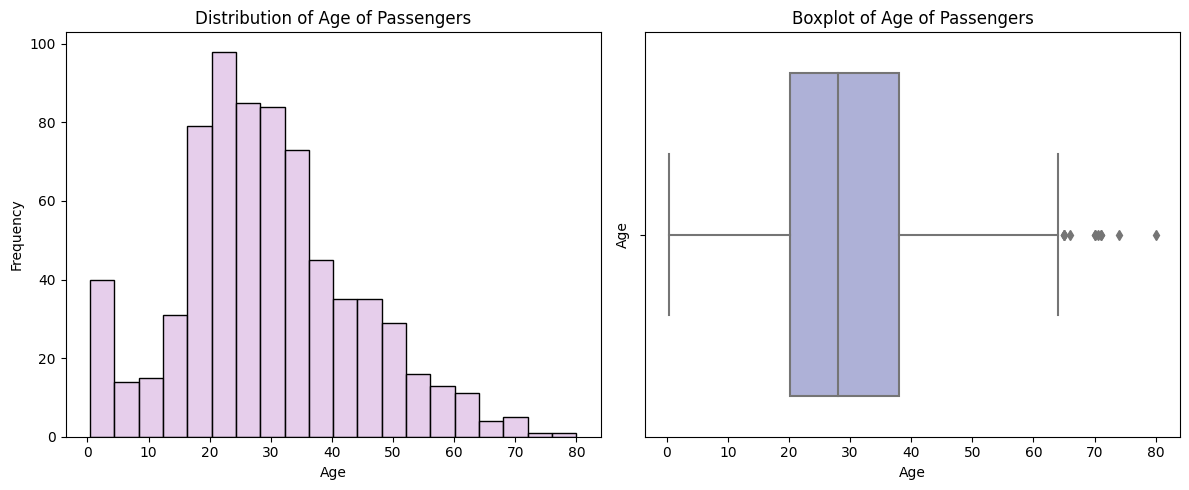

In [22]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=titanic['Age'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Distribution of Age of Passengers')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Age')

# Plot the boxplot
sns.boxplot(data=titanic, x="Age", color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of Age of Passengers')
axes[1].set_ylabel('Age')

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
titanic[titanic['Age']== 24]['Age'].count()

30

Mode is 24 but only 30 people in our dataset have that age. If we replace the null values(total 177) with only mode, the bar in the histogram will become taller. Hence we will deal with null values later after finding patterns in the data visualization step

Creating "Age Group" columns to create a interval based column based of "Age" column to catch any pattern in later analysis

In [24]:
bins = [0,12,18,25,40,60, float('inf')]
labels=[0,1,2,3,4,5]

titanic['Age Group'] = pd.cut(titanic['Age'], bins= bins,labels= labels,right = False)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,3
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,3
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,3
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,3
888,1,1,female,19.0,0,0,112053,30.0000,B42,S,2
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN


#### 2. Fare

In [25]:
titanic["Fare"].isna().sum()

0

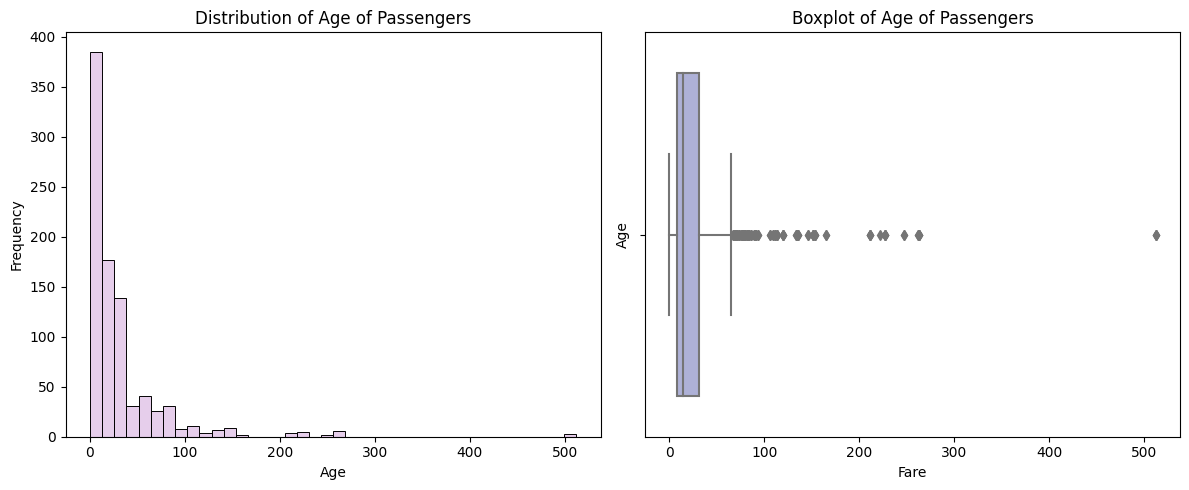

In [26]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=titanic['Fare'], color='#DEBEE5', ax=axes[0], bins = 40)
axes[0].set_title('Distribution of Age of Passengers')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Age')

# Plot the boxplot
sns.boxplot(data=titanic, x = 'Fare', color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of Age of Passengers')
axes[1].set_ylabel('Age')

# Adjust layout
plt.tight_layout()
plt.show()

Creating "Fare Group" columns to create a interval based column based of "Fare" column to catch any pattern in later analysis

In [27]:
bins = [0,25,50,100,200, float('inf')]
labels=[0,1,2,3,4]

titanic['Fare Group'] = pd.cut(titanic['Fare'], bins= bins,labels= labels,right = False)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group,Fare Group
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,3,2
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,0
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,3,2
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,3,0
888,1,1,female,19.0,0,0,112053,30.0000,B42,S,2,1
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,0


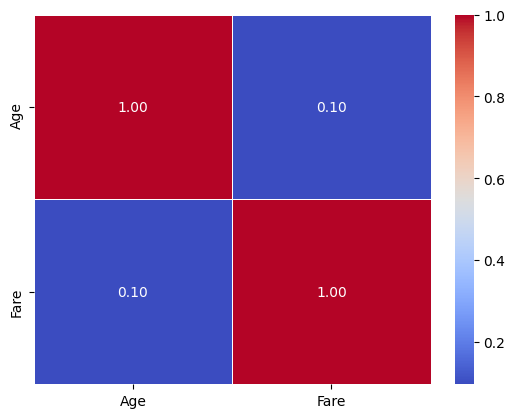

In [33]:

correlation_matrix = titanic[['Age','Fare']].corr()  # Compute the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.show()

### <h3 style="color:midnightblue">Categorical columns</h3>

#### 3.Pclass

#### For the remaining cateogorical columns,we will create a bar graph and box plot for each column to check for any patterns.

Note: Instead of using the same plotting code again and again, a function for visualization have been created below

In [34]:
def plot_grouped_bargraph_ratio(feature, target, feature_name, target_name):
    """
    Function to create a grouped bar chart with ratios.
    
    Parameters:
        feature (pd.Series): The feature column (series).
        target (pd.Series): The target column (series).
        feature_name (str): Name of the feature column (for labeling).
        target_name (str): Name of the target column (for labeling).
    """
    # Combine feature and target into a single DataFrame
    data = pd.DataFrame({feature_name: feature, target_name: target})
    
    # Calculate counts for each feature-target combination
    count_data = data.groupby([feature_name, target_name]).size().reset_index(name='Count')
    
    # Calculate total counts per feature to compute the ratio
    total_counts = count_data.groupby(feature_name)['Count'].transform('sum')
    count_data['Ratio'] = count_data['Count'] / total_counts
    
    # Plot the grouped bar chart
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x=feature_name, 
        y='Ratio', 
        hue=target_name, 
        data=count_data, 
        palette="mako"
    )
    plt.title(f'Grouped Bar Chart of {target_name} by {feature_name} (as Ratios)', fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Ratio', fontsize=12)
    plt.legend(title=target_name)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Ratios are between 0 and 1
    plt.show()

# Example usage:
# plot_grouped_bargraph_ratio(feature_series, target_series, "Feature Name", "Target Name")


In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_heatmap_counts(feature, target, feature_name, target_name):
    """
    Function to create a heatmap of counts for two categorical variables.
    
    Parameters:
        feature (pd.Series): The feature column (series).
        target (pd.Series): The target column (series).
        feature_name (str): Name of the feature column (for labeling).
        target_name (str): Name of the target column (for labeling).
    """
    # Combine feature and target into a single DataFrame
    data = pd.DataFrame({feature_name: feature, target_name: target})
    
    # Create a pivot table for the counts
    count_matrix = data.pivot_table(
        index=target_name, 
        columns=feature_name, 
        aggfunc='size', 
        fill_value=0
    )
    
    # Plot the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(count_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
    plt.title(f'Heatmap of Counts: {target_name} by {feature_name}', fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel(target_name, fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Example usage:
# Assuming `feature_series` and `target_series` are Pandas Series
# plot_heatmap_counts(feature_series, target_series, "Feature Name", "Target Name")


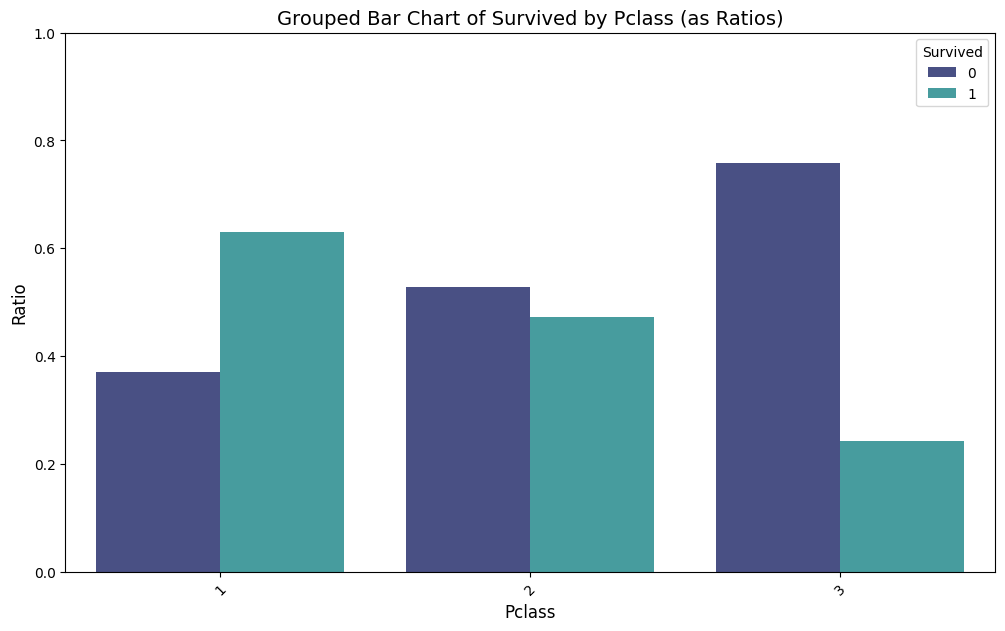

In [36]:
plot_grouped_bargraph_ratio(titanic['Pclass'],titanic['Survived'], "Pclass","Survived")

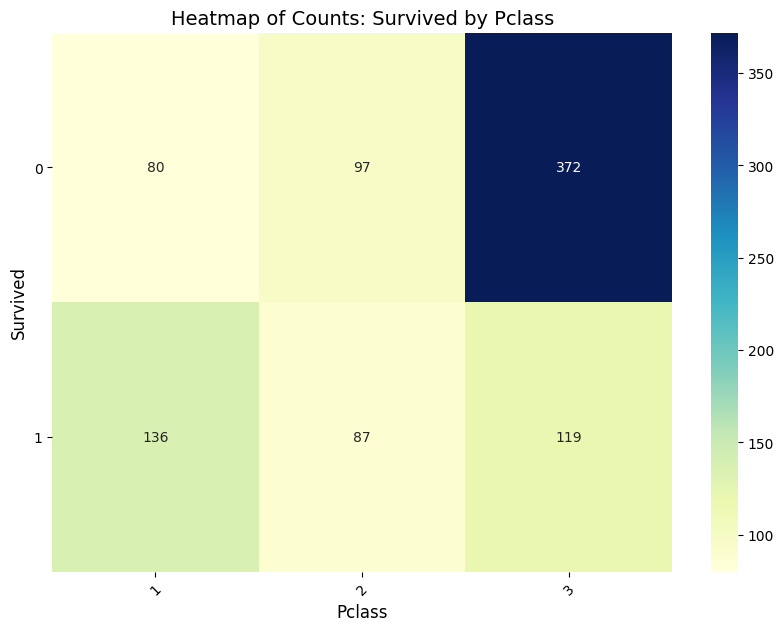

In [37]:
plot_heatmap_counts(titanic['Pclass'],titanic['Survived'], "Pclass","Survived")

#### 4. Sex

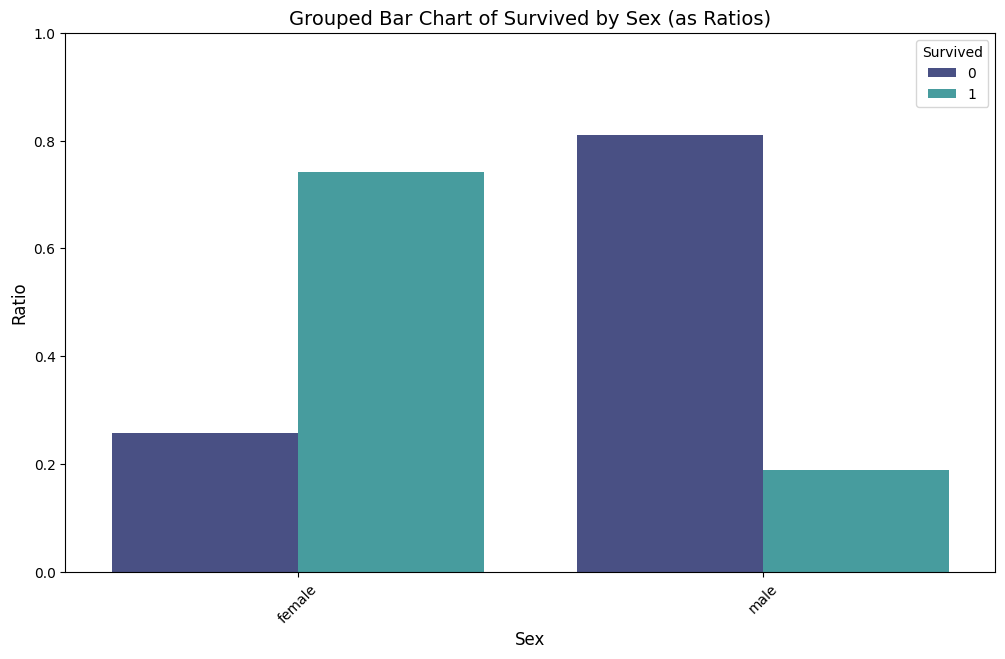

In [38]:
plot_grouped_bargraph_ratio(titanic['Sex'],titanic['Survived'], "Sex","Survived")

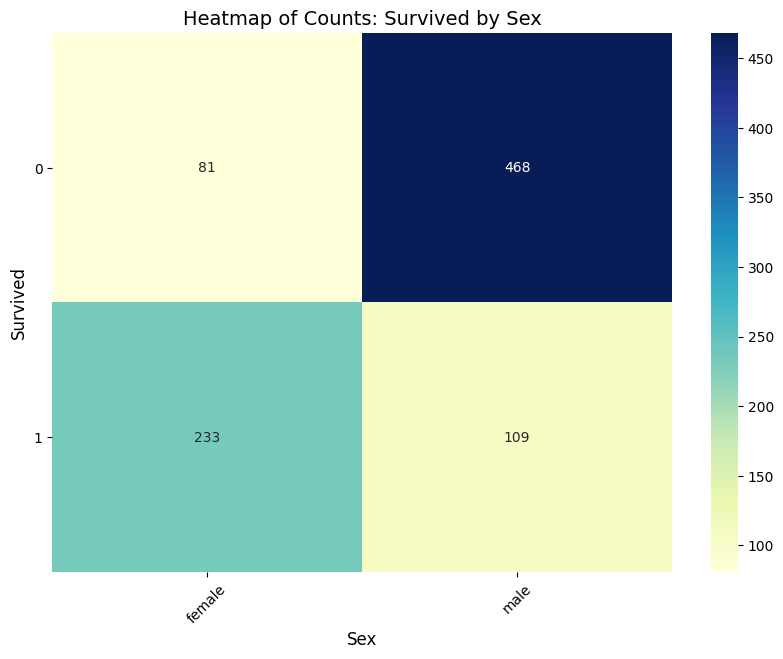

In [39]:
plot_heatmap_counts(titanic['Sex'],titanic['Survived'], "Sex","Survived")

#### 5. SibSp

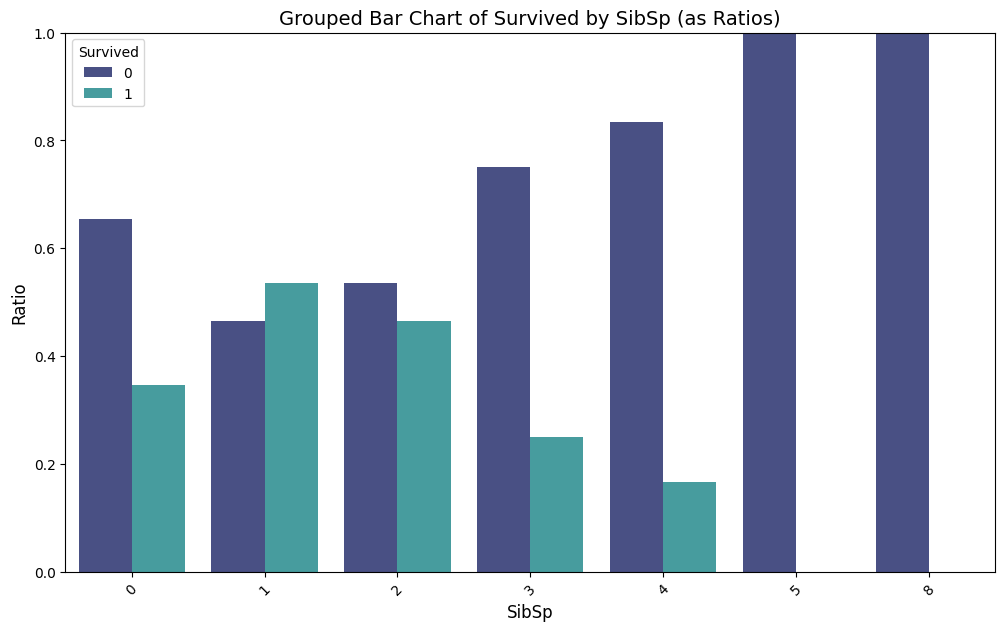

In [40]:
plot_grouped_bargraph_ratio(titanic['SibSp'],titanic['Survived'], "SibSp","Survived")

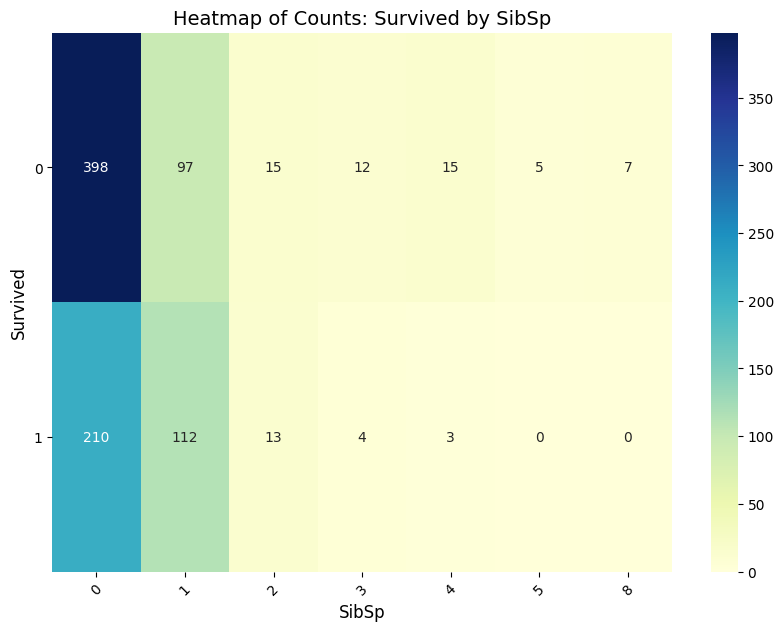

In [41]:
plot_heatmap_counts(titanic['SibSp'],titanic['Survived'], "SibSp","Survived")

#### 6. Parch

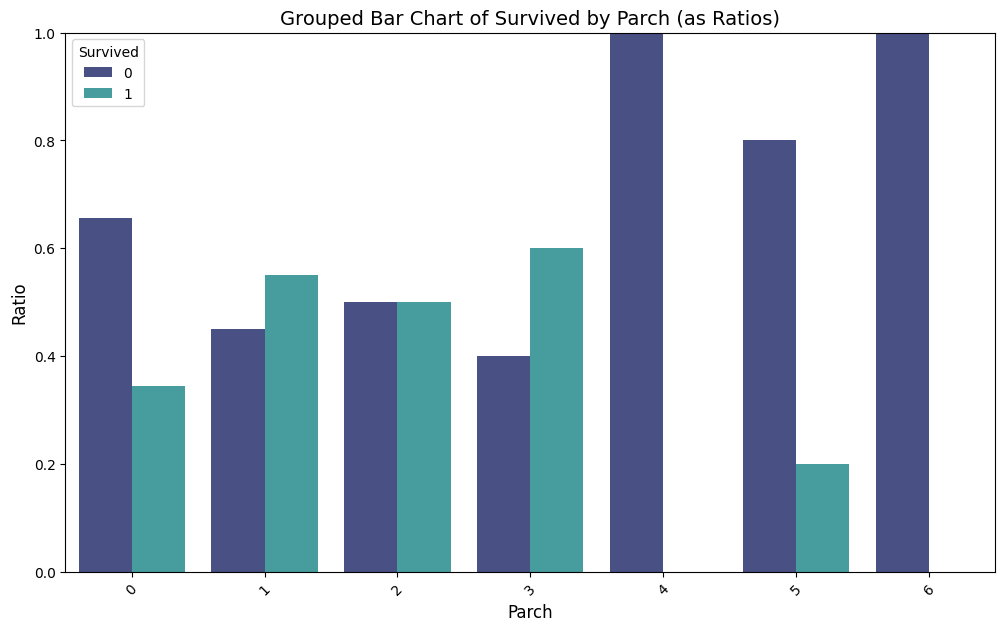

In [43]:
plot_grouped_bargraph_ratio(titanic['Parch'],titanic['Survived'], "Parch","Survived")

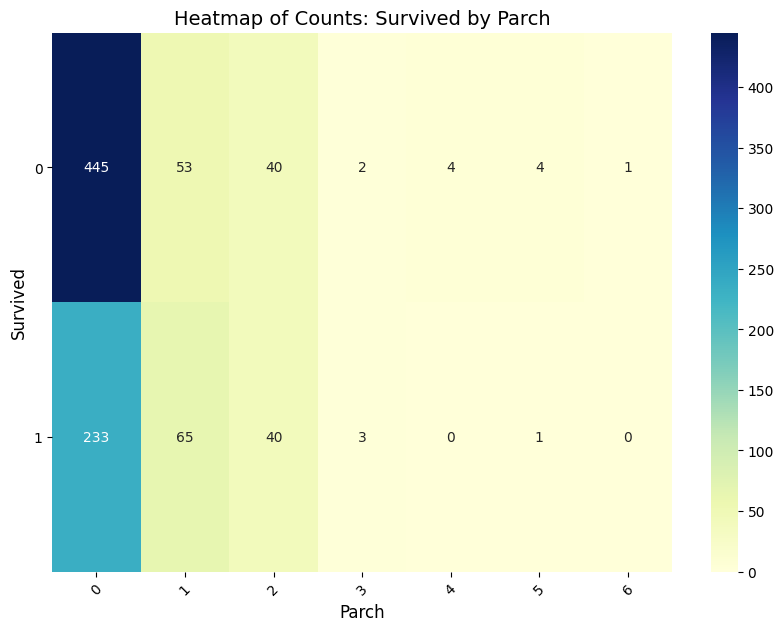

In [44]:
plot_heatmap_counts(titanic['Parch'],titanic['Survived'], "Parch","Survived")

#### 7. Cabin

In [45]:
titanic['Cabin'].nunique()

147

In [46]:
titanic[titanic["Cabin"].str.startswith("T", na=False)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group,Fare Group
PassengerId,,,,,,,,,,,,
340,0,1,male,45.0,0,0,113784,35.5,T,S,4,1


In [47]:
titanic["Cabin_class"] = titanic["Cabin"].str[0]
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group,Fare Group,Cabin_class
PassengerId,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,NaN
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,3,2,C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,0,NaN
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,3,2,C
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,3,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,3,0,NaN
888,1,1,female,19.0,0,0,112053,30.0000,B42,S,2,1,B
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,0,NaN


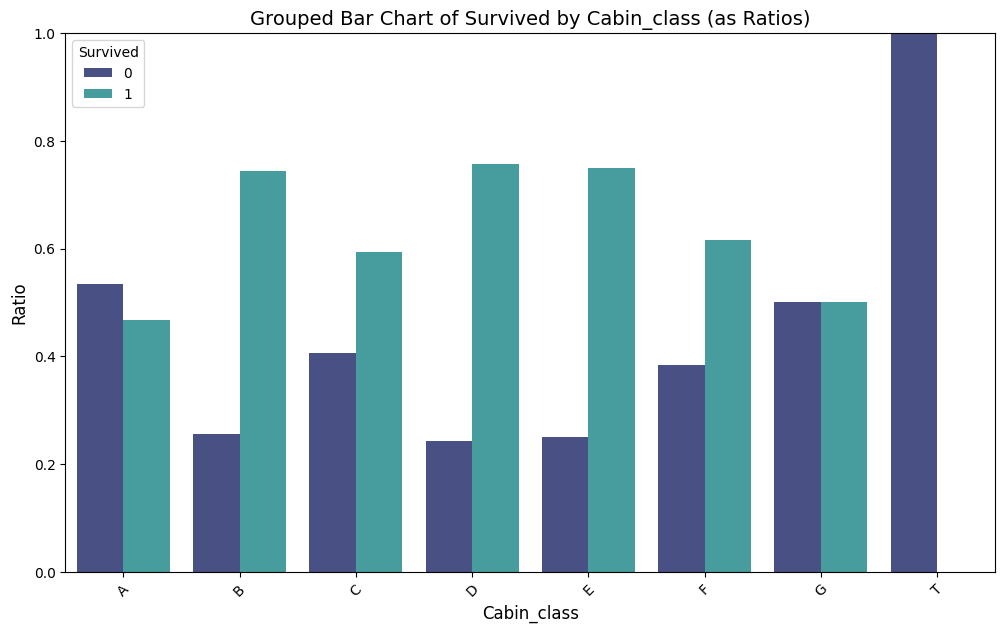

In [48]:
plot_grouped_bargraph_ratio(titanic['Cabin_class'],titanic['Survived'], "Cabin_class","Survived")

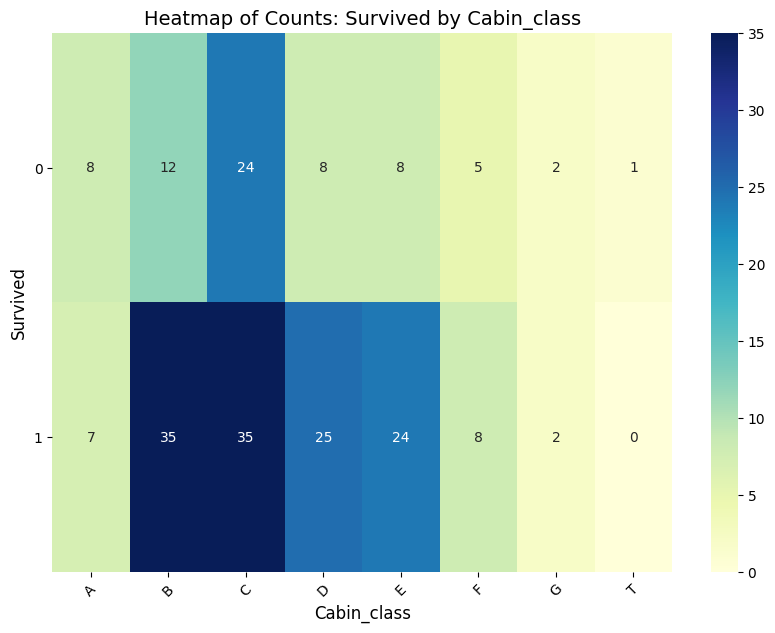

In [49]:
plot_heatmap_counts(titanic['Cabin_class'],titanic['Survived'], "Cabin_class","Survived")

#### 8. Embarked

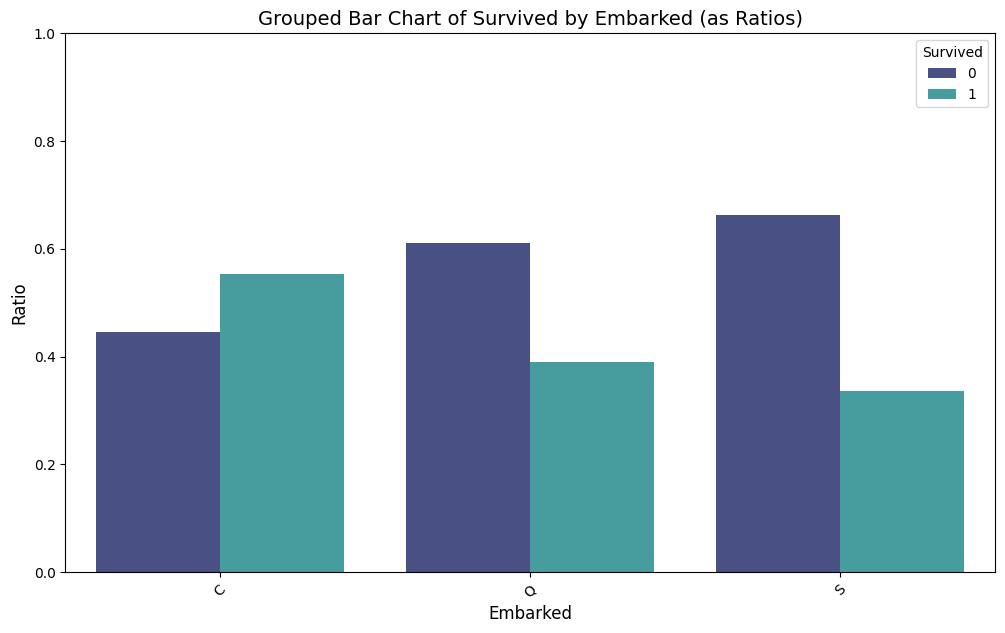

In [50]:
plot_grouped_bargraph_ratio(titanic['Embarked'],titanic['Survived'], "Embarked","Survived")

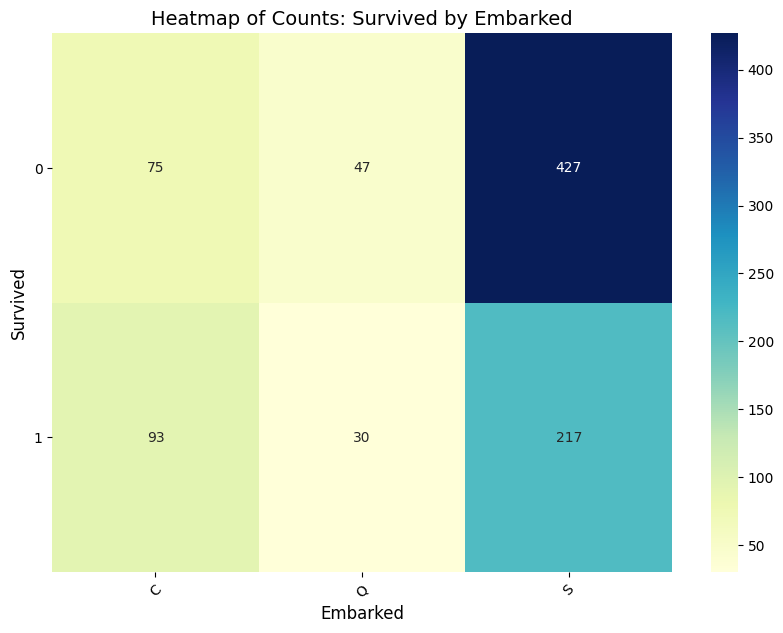

In [51]:
plot_heatmap_counts(titanic['Embarked'],titanic['Survived'], "Embarked","Survived")

In [52]:
titanic["Alone"]=1
titanic.loc[(titanic['SibSp'].astype(int)== 0) & (titanic['Parch'].astype(int) == 0),"Alone"]= 0

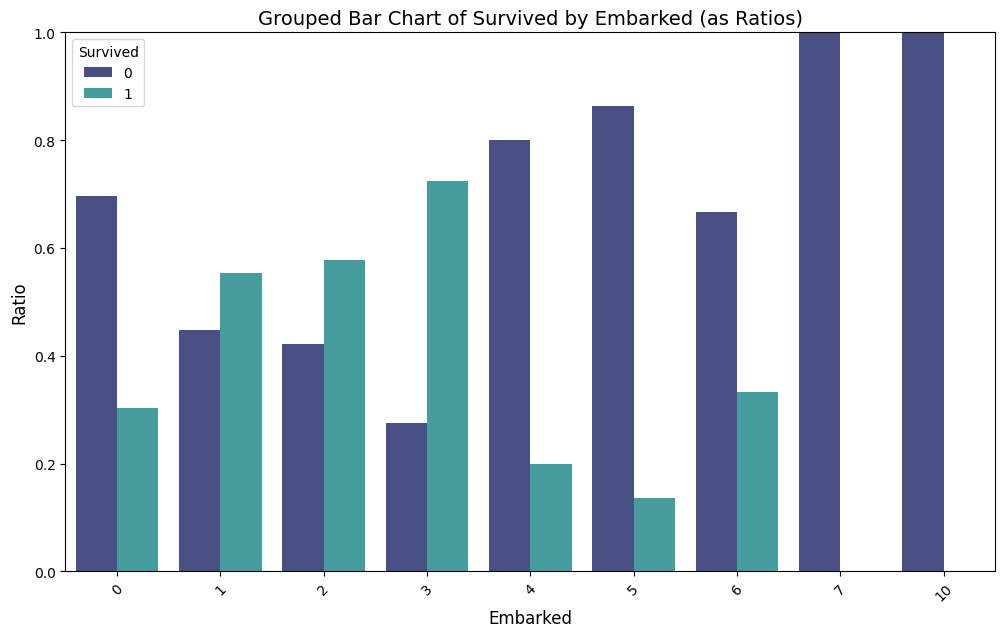

In [53]:
titanic["Dependants"]=titanic['SibSp'] + titanic['Parch']
plot_grouped_bargraph_ratio(titanic['Dependants'],titanic['Survived'], "Embarked","Survived")

### <h2 style="color:purple">d. Cramer's V</h2>

In [54]:

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """
    Calculate Cramér's V for two categorical variables.
    
    Args:
        x (pd.Series): Categorical predictor variable.
        y (pd.Series): Categorical target variable.
    
    Returns:
        float: Cramér's V value.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    
    # Perform the Chi-Square test
    chi2, _, _, _ = chi2_contingency(contingency_table)
    
    # Get the total number of observations
    n = contingency_table.sum().sum()
    
    # Calculate the number of categories for each variable
    k = contingency_table.shape[0]  # Rows
    r = contingency_table.shape[1]  # Columns
    
    # Compute Cramér's V
    v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
    return v


In [55]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Pclass'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.33981738800531175


In [56]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Sex'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.5409359434469282


In [57]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['SibSp'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.2045273023663305


In [58]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Parch'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.177036916072161


In [59]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Cabin_class'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.2247063041069494


In [60]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Embarked'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.17261682709984438


In [61]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Age Group'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.13901726788770685


In [62]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Fare Group'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.3049852450634079


In [63]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Alone'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.20100899932318902


In [64]:
# Calculate Cramér's V
cramers_v_value = cramers_v(titanic['Dependants'], titanic['Survived'])
print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.30090084245430265


According to Cramer's V:
1. Pclass
2.Sex
3. Fare Group
4. Dependants

looks like have a good association with out target variable

Followed by

4. SibSp
5. Parch
6. Embarked

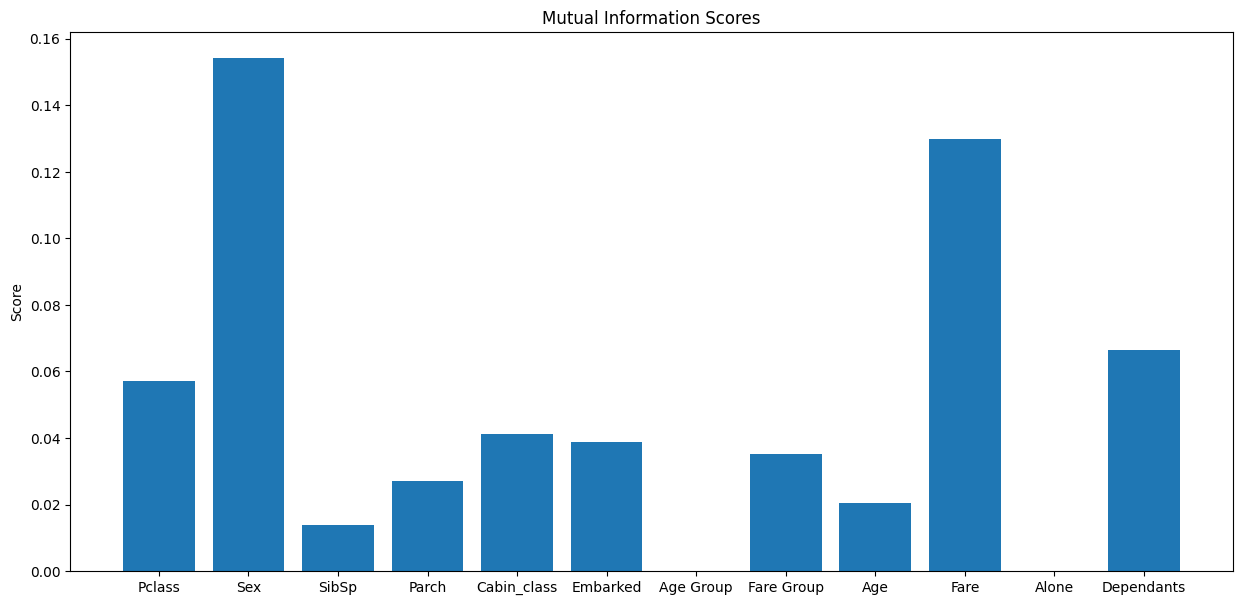

array([0.05715174, 0.15426804, 0.01389709, 0.02717736, 0.04109449,
       0.03874412, 0.        , 0.03507841, 0.02055376, 0.12986329,
       0.        , 0.06644966])

In [65]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
data_encoded = titanic.apply(LabelEncoder().fit_transform)

# Calculate MI for all predictors
mi_scores = mutual_info_classif(data_encoded[['Pclass', 'Sex','SibSp','Parch','Cabin_class','Embarked','Age Group','Fare Group','Age','Fare',"Alone","Dependants"]], titanic['Survived'])

# Plot MI Scores
plt.figure(figsize=(15, 7))
plt.bar(['Pclass', 'Sex','SibSp','Parch','Cabin_class','Embarked','Age Group','Fare Group','Age','Fare','Alone','Dependants'], mi_scores)
plt.title('Mutual Information Scores')
plt.ylabel('Score')
plt.show()
mi_scores

According to Mutual Information Score, the following  features have high score

1. Pclass
2. Sex
3. Cabin_class
4.Fare
5.Fare Group

If you run the above code multiple times, only these features have high bars.

1. Pclass
2. Sex
3. Fare

Followed by some average scores for the following:

1. Cabin_class
2. Fare Group
3. Dependants

## <h1 style="color:indigo">2.  Data Preprocessing</h1>

### <h2 style="color:purple">a. Handling Null Values</h2>

We will check how the Age column is changing with other columns like SibSp, Parch and Pclass

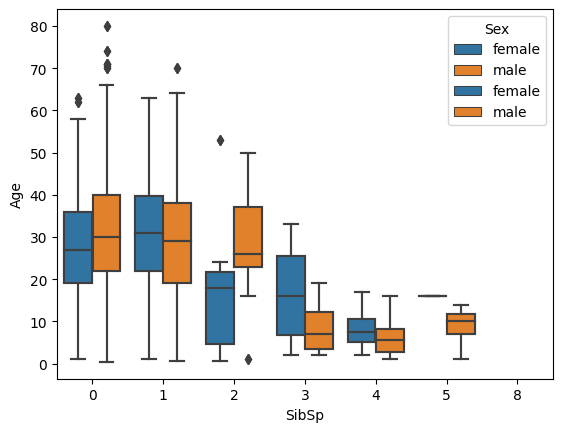

In [67]:
sns.boxplot(x='SibSp',y='Age',hue='Sex',data=titanic)
plt.show()

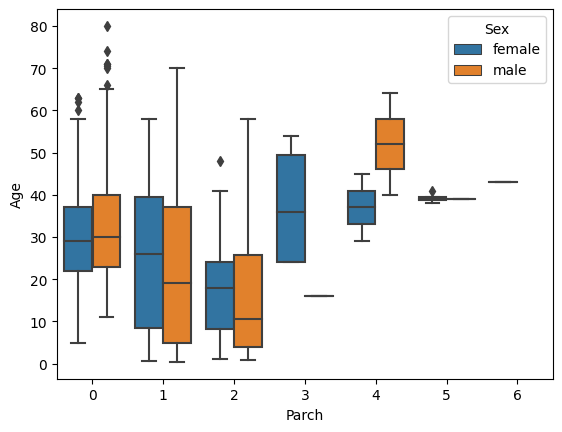

In [68]:
sns.boxplot(x='Parch',y='Age',hue='Sex',data=titanic)
plt.show()

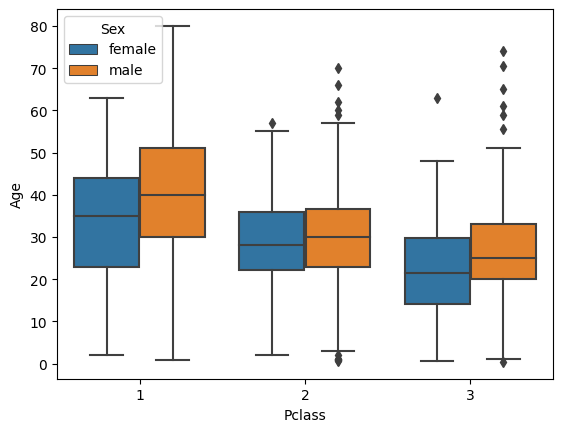

In [69]:
sns.boxplot(x='Pclass',y='Age',hue='Sex',data=titanic)
plt.show()

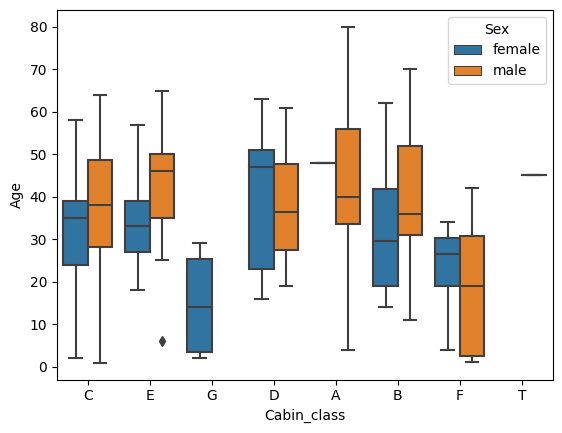

In [70]:
sns.boxplot(x='Cabin_class',y='Age',hue='Sex',data=titanic)
plt.show()

In [71]:
titanic.groupby(['SibSp', 'Parch'])['Age'].median()

SibSp  Parch
0      0        29.5
       1        27.0
       2        20.5
       3        24.0
       4        29.0
       5        40.0
1      0        30.0
       1        30.5
       2        24.0
       3        48.0
       4        45.0
       5        39.0
       6        43.0
2      0        28.0
       1         4.0
       2        19.5
       3        24.0
3      0        31.5
       1         3.0
       2        10.0
4      1         7.0
       2         6.0
5      2        11.0
8      2         NaN
Name: Age, dtype: float64

We will check if these values have made any difference to the distribution

7


<Figure size 640x480 with 0 Axes>

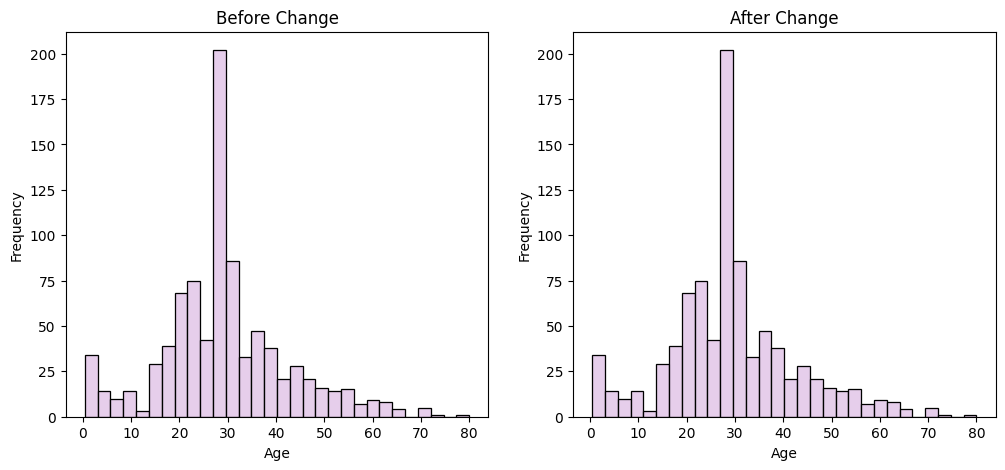

In [76]:
plt.clf()
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=titanic['Age'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Before Change')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Age')

# Group-based imputation
titanic['Age'] = titanic.groupby(['SibSp', 'Parch'])['Age'].transform(lambda x: x.fillna(x.median()))

# Verify if null values are imputed
print(titanic['Age'].isnull().sum())

# Plot the histogram
sns.histplot(data=titanic['Age'], color='#DEBEE5', ax=axes[1])
axes[1].set_title('After Change')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Age')
plt.show()

In [77]:
titanic[titanic['Age'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group,Fare Group,Cabin_class,Alone,Dependants
PassengerId,,,,,,,,,,,,,,,
160,0,3,male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,2,NaN,1,10
181,0,3,female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,2,NaN,1,10
202,0,3,male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,2,NaN,1,10
325,0,3,male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,2,NaN,1,10
793,0,3,female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,2,NaN,1,10
847,0,3,male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,2,NaN,1,10
864,0,3,female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,2,NaN,1,10


They looks like they belong to the same family and only one of the survived. We will do another group based imputation based "Parch" column only. 

In [78]:
# Group-based imputation
titanic['Age'] = titanic.groupby(['Parch'])['Age'].transform(lambda x: x.fillna(x.median()))

# Verify if null values are imputed
print(titanic['Age'].isnull().sum())

0


In [171]:
bins = [0,12,18,25,40,60, float('inf')]
labels=[0,1,2,3,4,5]

titanic['Age Group'] = pd.cut(titanic['Age'], bins= bins,labels= labels,right = False)

In [168]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group,Fare Group,Cabin_class,Alone,Dependants
PassengerId,,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,NaN,1,1
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,3,2,C,1,1
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,0,NaN,0,0
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,3,2,C,1,1
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,3,0,NaN,0,0


In [80]:
titanic.isnull().sum()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Age Group      177
Fare Group       0
Cabin_class    687
Alone            0
Dependants       0
dtype: int64

We are going to drop the column Cabin_class because more than 75% percentage of data is null. Cabin_class had good potiential to be good predictor if it had more accurate values



In [81]:
titanic['Pclass'].unique()

[3, 1, 2]
Categories (3, int64): [1, 2, 3]

In [82]:
titanic['Sex'].unique()

['male', 'female']
Categories (2, object): ['female', 'male']

In [83]:
titanic['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [84]:
titanic['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [85]:
titanic['Embarked'].unique()

['S', 'C', 'Q', NaN]
Categories (3, object): ['C', 'Q', 'S']

In [86]:
titanic['Embarked'] = titanic['Embarked'].cat.add_categories('Unknown')
titanic['Embarked'].fillna('Unknown')

PassengerId
1      S
2      C
3      S
4      S
5      S
      ..
887    S
888    S
889    S
890    C
891    Q
Name: Embarked, Length: 891, dtype: category
Categories (4, object): ['C', 'Q', 'S', 'Unknown']

In [87]:
titanic[["Age","Fare"]].describe()

,Age,Fare
count,891.000000,891.000000
mean,29.414893,32.204208
std,13.177185,49.693429
min,0.420000,0.000000
25%,22.000000,7.910400
50%,29.500000,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


In [88]:
titanic_preprocessed = titanic[["Age","Fare"]]
import pickle
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(titanic_preprocessed)
scaled_df = scaler.transform(titanic_preprocessed)
titanic_preprocessed = pd.DataFrame(scaled_df,columns=titanic_preprocessed.columns, index =titanic_preprocessed.index)



In [172]:
titanic_preprocessed["Pclass"] = titanic["Pclass"].copy()
titanic_preprocessed["SibSp"] = titanic["SibSp"].copy()
titanic_preprocessed["Parch"]= titanic["Parch"].copy() 
titanic_preprocessed["Dependants"] = titanic["Dependants"].copy()
titanic_preprocessed["Fare Group"] = titanic["Fare Group"].copy()
titanic_preprocessed["Age Group"] = titanic["Age Group"].copy()
titanic_preprocessed["Alone"] = titanic["Alone"].copy()
titanic_preprocessed.head()

,Age,Fare,Pclass,SibSp,Parch,Dependants,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Fare Group,Age Group,Alone
PassengerId,,,,,,,,,,,,,
1,0.271174,0.014151,3,1,0,1,1,0,0,1,0,2,1
2,0.472229,0.139136,1,1,0,1,0,1,0,0,2,3,1
3,0.321438,0.015469,3,0,0,0,0,0,0,1,0,3,0
4,0.434531,0.103644,1,1,0,1,0,0,0,1,2,3,1
5,0.434531,0.015713,3,0,0,0,1,0,0,1,0,3,0


We are not going to use one hot encoding in Pclass, because it is Ordinal.

In [90]:
temp = pd.get_dummies(titanic[["Sex","Embarked"]])
encoded = pd.DataFrame(temp[["Sex_male","Embarked_C","Embarked_Q","Embarked_S"]], index = titanic_preprocessed.index)
titanic_preprocessed = pd.concat([titanic_preprocessed, encoded], axis = 1)
titanic_preprocessed.head()

,Age,Fare,Pclass,SibSp,Parch,Dependants,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0.271174,0.014151,3,1,0,1,1,0,0,1
2,0.472229,0.139136,1,1,0,1,0,1,0,0
3,0.321438,0.015469,3,0,0,0,0,0,0,1
4,0.434531,0.103644,1,1,0,1,0,0,0,1
5,0.434531,0.015713,3,0,0,0,1,0,0,1


In [91]:
titanic_preprocessed.shape

(891, 10)

In [102]:
y =titanic['Survived']
y.shape

(891,)

In [101]:
sum(y==1)

342

In [100]:
sum(y==0)

549

In [173]:
titanic_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Age         891 non-null    float64 
 1   Fare        891 non-null    float64 
 2   Pclass      891 non-null    category
 3   SibSp       891 non-null    int64   
 4   Parch       891 non-null    int64   
 5   Dependants  891 non-null    int64   
 6   Sex_male    891 non-null    uint8   
 7   Embarked_C  891 non-null    uint8   
 8   Embarked_Q  891 non-null    uint8   
 9   Embarked_S  891 non-null    uint8   
 10  Fare Group  891 non-null    category
 11  Age Group   891 non-null    category
 12  Alone       891 non-null    int64   
dtypes: category(3), float64(2), int64(4), uint8(4)
memory usage: 55.4 KB


In [115]:
titanic_preprocessed['Pclass'] = titanic_preprocessed['Pclass'].astype('int')

#### <h3 style="color:midnightblue">Train test split</h3>

In [175]:
X_train,X_test,y_train,y_test = train_test_split(titanic_preprocessed,y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((712, 13), (179, 13), (712,), (179,))

#### <h3 style="color:midnightblue">SMOTE</h3>

Since the minority class is important, we need to handle the imbalance to ensure the model performs well for both classes.

We will use SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples for the minority class

In [176]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


## <h1 style="color:indigo">3.  Building Model</h1>

Evaluation metric we will use :
1. Precision
2. Recall
3. F1 score
4. Accuracy


In [177]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted"),
    }
    return metrics


In [178]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

1. XGBoost

In [179]:
xgb = XGBClassifier(random_state=42, enable_categorical=True)
xgb.fit(X_train, y_train)
xgb_metrics = evaluate_model(xgb, X_test, y_test)

2. LightGBM

In [180]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_metrics = evaluate_model(lgbm, X_test, y_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [198]:
# Get feature importance
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)


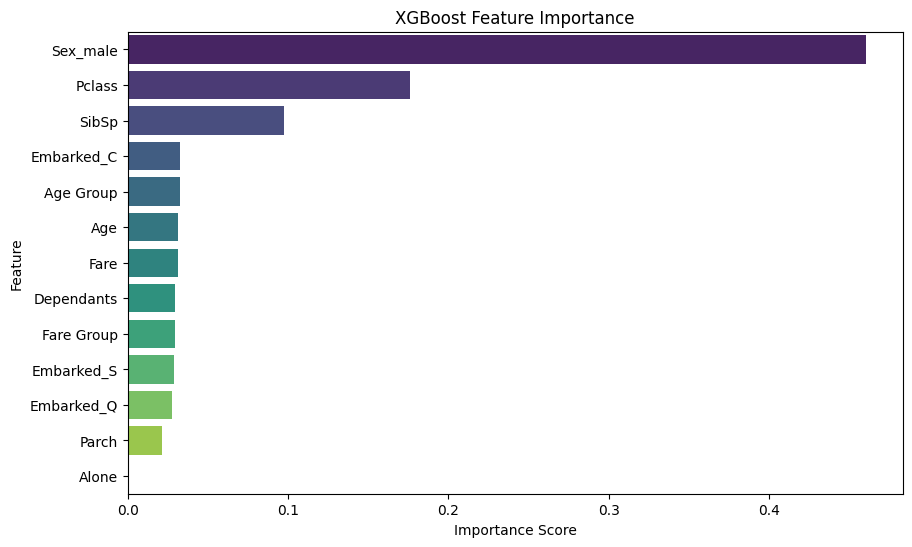

In [199]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()


We will remove some of the least important features from the feature set before we fine tune using hyperparameter tuning

In [200]:
X = titanic_preprocessed.drop(columns=['Alone','Parch','Fare Group'])

In [208]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((712, 10), (179, 10), (712,), (179,))

In [209]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


#### <h3 style="color:midnightblue">XGBoost</h3>

In [210]:
clf = XGBClassifier(enable_categorical=True)

In [211]:
# Set up parameters for grid search
parameters = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                'max_depth': [2, 4, 6, 8, 10],
                'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]
                }

# Set up grid search
grid_search = GridSearchCV(estimator=clf, param_grid=parameters, 
                           scoring='accuracy', 
                           cv=5, 
                           n_jobs=-1)

In [212]:
grid_search.fit(X_resampled,y_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
             scoring='accuracy')

In [213]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 40, 'subsample': 0.7}

In [214]:
best_model = grid_search.best_estimator_

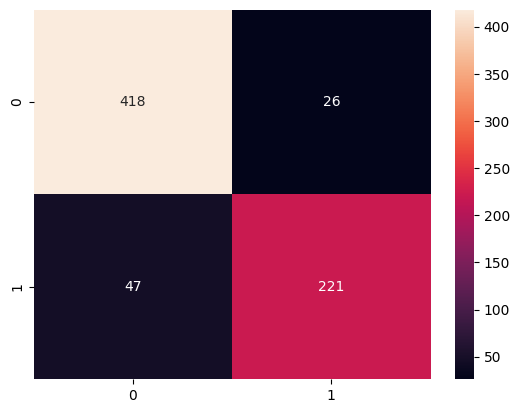

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       444
           1       0.89      0.82      0.86       268

    accuracy                           0.90       712
   macro avg       0.90      0.88      0.89       712
weighted avg       0.90      0.90      0.90       712



In [215]:
yhat_train = best_model.predict(X_train)
cm = confusion_matrix(y_train,yhat_train)
sns.heatmap(cm, annot=True,fmt='d')
plt.show()
print(classification_report(y_train,yhat_train))

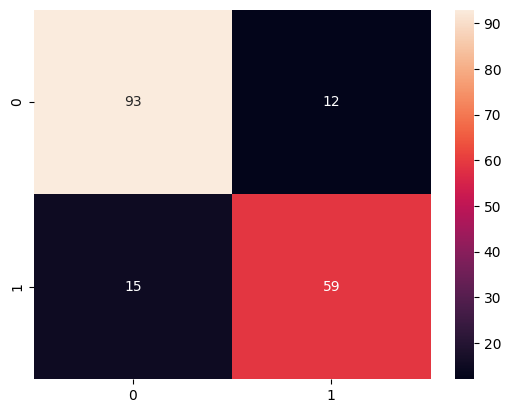

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       105
           1       0.83      0.80      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



In [216]:
yhat_test = best_model.predict(X_test)
cm = confusion_matrix(y_test,yhat_test)
sns.heatmap(cm, annot=True,fmt='d')
plt.show()
print(classification_report(y_test,yhat_test))

#### <h3 style="color:midnightblue">LightGBM</h3>

In [217]:
# specify your configurations as a dict
params = {
    'num_leaves': [8,12,24,32],
    'learning_rate': [0.05,0.01,0.02,0.001],
    'feature_fraction': [0.9,0.8,0.7,0.6,0.5],
    'bagging_fraction': [0.9,0.8,0.7,0.6,0.5],
}

In [218]:
lg_clf = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='binary_logloss')

In [219]:
lggrid_search = GridSearchCV(estimator=lg_clf, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)

In [220]:
lggrid_search.fit(X_resampled,y_resampled) 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 444, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 888, number of used features: 10
[LightGBM] [Info] [bi

GridSearchCV(cv=5,
             estimator=LGBMClassifier(metric='binary_logloss',
                                      objective='binary'),
             n_jobs=-1,
             param_grid={'bagging_fraction': [0.9, 0.8, 0.7, 0.6, 0.5],
                         'feature_fraction': [0.9, 0.8, 0.7, 0.6, 0.5],
                         'learning_rate': [0.05, 0.01, 0.02, 0.001],
                         'num_leaves': [8, 12, 24, 32]},
             scoring='accuracy')

In [221]:
lggrid_search.best_params_

{'bagging_fraction': 0.9,
 'feature_fraction': 0.6,
 'learning_rate': 0.05,
 'num_leaves': 32}

In [222]:
lg_model = lggrid_search.best_estimator_
lg_model

LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.6, learning_rate=0.05,
               metric='binary_logloss', num_leaves=32, objective='binary')

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


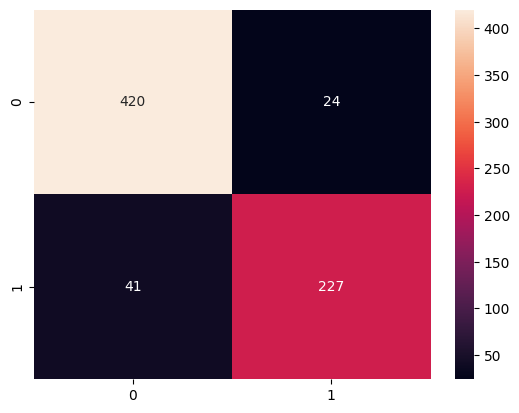

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       444
           1       0.90      0.85      0.87       268

    accuracy                           0.91       712
   macro avg       0.91      0.90      0.90       712
weighted avg       0.91      0.91      0.91       712



In [223]:
yhat_train = lg_model.predict(X_train)
cm = confusion_matrix(y_train,yhat_train)
sns.heatmap(cm, annot=True,fmt='d')
plt.show()
print(classification_report(y_train,yhat_train))

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


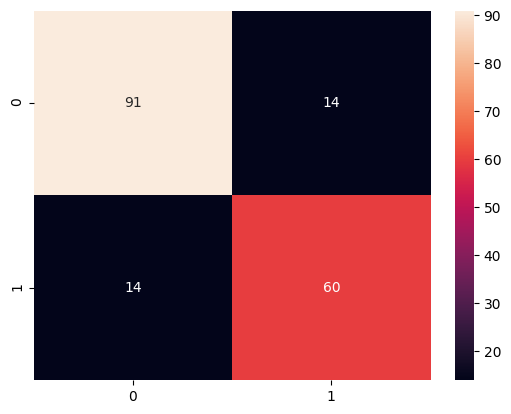

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       105
           1       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



In [224]:
yhat_test = lg_model.predict(X_test)
cm = confusion_matrix(y_test,yhat_test)
sns.heatmap(cm, annot=True,fmt='d')
plt.show()
print(classification_report(y_test,yhat_test))

In [225]:
# Evaluate tuned models
best_xgb_metrics = evaluate_model(best_model, X_test, y_test)
best_lgbm_metrics = evaluate_model(lg_model, X_test, y_test)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


## <h1 style="color:indigo">4.  Comparative Analysis</h1>

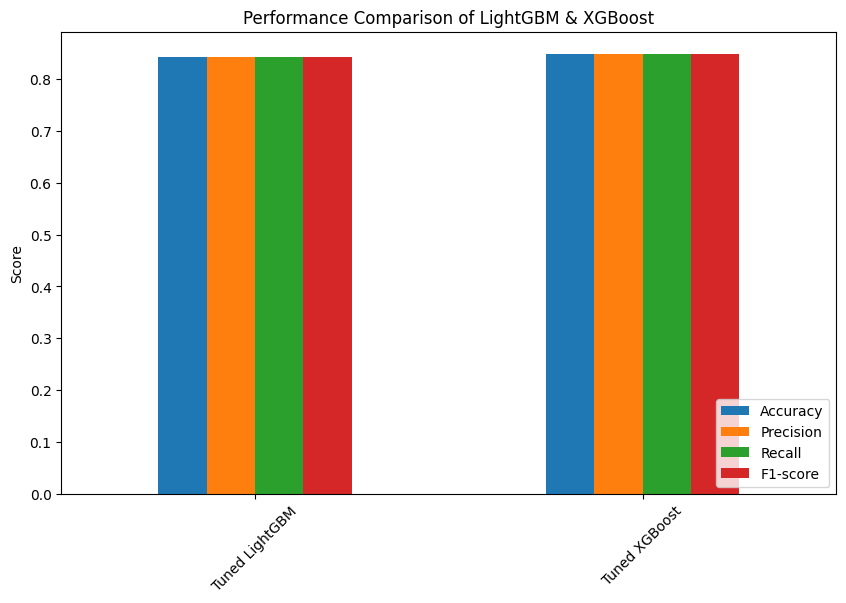

In [226]:
import matplotlib.pyplot as plt

metrics_df = pd.DataFrame([ best_lgbm_metrics, best_xgb_metrics],
                          index=[ "Tuned LightGBM", "Tuned XGBoost"])

metrics_df.plot(kind="bar", figsize=(10, 6))
plt.title("Performance Comparison of LightGBM & XGBoost")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


In [232]:
xg_proba = best_model.predict_proba(X_test)[:, 1]
lg_proba = lg_model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


In [234]:
# 🔹 Step 5: Compute ROC-AUC Score
xgb_auc = roc_auc_score(y_test, xg_proba)
lgb_auc = roc_auc_score(y_test, lg_proba)

print(f"XGBoost AUC: {xgb_auc:.4f}")
print(f"LightGBM AUC: {lgb_auc:.4f}")


XGBoost AUC: 0.8998
LightGBM AUC: 0.9050


We can see that LightGBM has slightly higher score than xgboost. Let's check if the difference is something to be considered

#### <h3 style="color:midnightblue">Check if the difference is statistically significant</h3>

In [236]:
from mlxtend.evaluate import permutation_test

p_value = permutation_test(xg_proba, lg_proba, method='approximate', num_rounds=10000, seed=42)
print(f"P-value: {p_value}")


P-value: 0.9217078292170783


- The difference between XGBoost and LightGBM is NOT statistically significant.
- The models are performing almost identically, and any small AUC difference (0.9050 vs. 0.8998) is likely due to randomness.

#### <h3 style="color:midnightblue">Compare Precision-Recall Curves</h3>

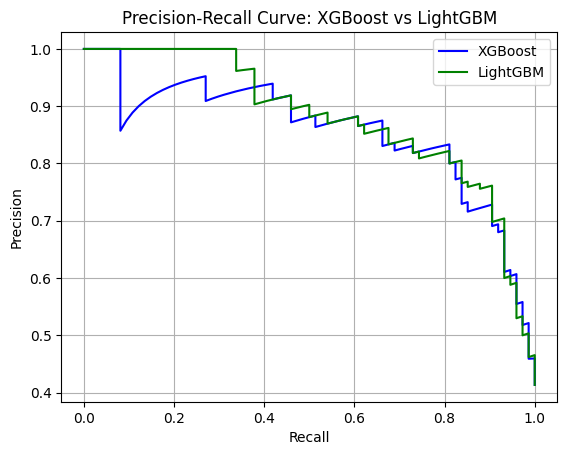

In [237]:
from sklearn.metrics import precision_recall_curve

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xg_proba)
lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, lg_proba)

plt.plot(xgb_recall, xgb_precision, label="XGBoost", color='blue')
plt.plot(lgb_recall, lgb_precision, label="LightGBM", color='green')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: XGBoost vs LightGBM")
plt.legend()
plt.grid()
plt.show()


Both models perform similarly, with overlapping curves.
- LightGBM slightly outperforms XGBoost at lower recall values (left side of the graph), meaning it maintains high precision when detecting positive cases.
-  At higher recall values (right side), both models behave almost the same, meaning they trade off precision for more recall at similar rates.
- As we have little imbalance in the dataset, precision-recall is a better metric than AUC—and here, LightGBM has a slight edge.

**We will check if an ensemble of XGB and LightGBM improve the performance.**

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
XGBoost AUC: 0.8998, AP: 0.8581
LightGBM AUC: 0.9050, AP: 0.8813
Ensemble AUC: 0.9051, AP: 0.8785


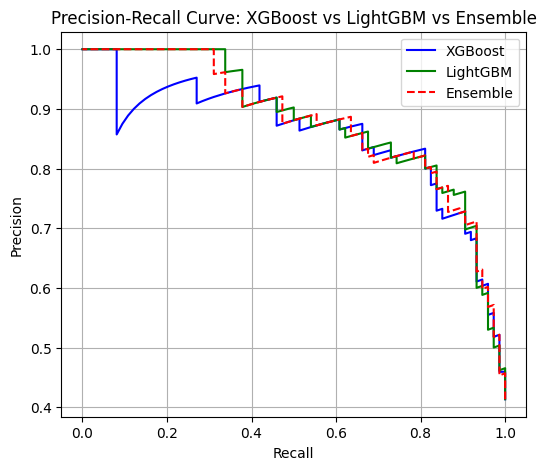

In [238]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

# Get probability predictions from both models
xgb_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
lgb_probs = lg_model.predict_proba(X_test)[:, 1]

#  Create ensemble predictions (simple averaging)
ensemble_probs = (xgb_probs + lgb_probs) / 2

#  Compute AUC & AP scores
auc_xgb = roc_auc_score(y_test, xgb_probs)
auc_lgb = roc_auc_score(y_test, lgb_probs)
auc_ensemble = roc_auc_score(y_test, ensemble_probs)

ap_xgb = average_precision_score(y_test, xgb_probs)
ap_lgb = average_precision_score(y_test, lgb_probs)
ap_ensemble = average_precision_score(y_test, ensemble_probs)

print(f"XGBoost AUC: {auc_xgb:.4f}, AP: {ap_xgb:.4f}")
print(f"LightGBM AUC: {auc_lgb:.4f}, AP: {ap_lgb:.4f}")
print(f"Ensemble AUC: {auc_ensemble:.4f}, AP: {ap_ensemble:.4f}")

# Plot Precision-Recall Curves
plt.figure(figsize=(6, 5))
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, lgb_probs)
ensemble_precision, ensemble_recall, _ = precision_recall_curve(y_test, ensemble_probs)

plt.plot(xgb_recall, xgb_precision, label="XGBoost", color="blue")
plt.plot(lgb_recall, lgb_precision, label="LightGBM", color="green")
plt.plot(ensemble_recall, ensemble_precision, label="Ensemble", color="red", linestyle="dashed")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: XGBoost vs LightGBM vs Ensemble")
plt.legend()
plt.grid()
plt.show()


**As recall is the metric we are mostly focusing on, we will compare the recall between all three models**

In [241]:
from sklearn.metrics import recall_score

# Convert probabilities to binary predictions using a threshold (0.5)
xgb_preds = (xgb_probs >= 0.5).astype(int)
lgb_preds = (lgb_probs >= 0.5).astype(int)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# Compute Recall
recall_xgb = recall_score(y_test, xgb_preds)
recall_lgb = recall_score(y_test, lgb_preds)
recall_ensemble = recall_score(y_test, ensemble_preds)

print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"LightGBM Recall: {recall_lgb:.4f}")
print(f"Ensemble Recall: {recall_ensemble:.4f}")


XGBoost Recall: 0.7973
LightGBM Recall: 0.8108
Ensemble Recall: 0.7973


From the comparison we can say that, LightGBM slightly performs better even though the difference is not that huge. Ensembling both the models doesn't really add any value